## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import logging

from PySONIC.utils import logger, si_format
from PySONIC.neurons import getPointNeuron
from ExSONIC.core import PlanarDiskTransducerSource, SonicFiber, myelinatedFiberReilly, strengthDuration
from ExSONIC.plt import SectionCompTimeSeries, strengthDurationCurve, strengthDistanceCurve

## Transducer 1

In [2]:
u_z = 1                          # transducer surface velocity (m/s)
r_tr = (19e-3) / 2             # transducer radius (m)
x0 = 0                           # transducer location x-axis (m)
y0 = 0                           # transducer location y-axis (m)
z0 = 0                           # transducer location z-axis (m)
Fdrive = 0.5e6   # US frequency
psource = PlanarDiskTransducerSource((x0, y0, z0), Fdrive, u_z, r=r_tr) #310

In [7]:
def plotAmpDist(x, z, amps, refamps):
    # Plot amplitude distribution along normal axis and over 2D field
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.80)
    ax = axes[0]
    ax.set_title('Acoustic amplitude distribution along the normal axis')
    ax.set_xlabel('axial distance (mm)')
    ax.set_ylabel('Amplitude (kPa)')
    ax.plot(z * 1e3, amps[int(x.size / 2), :] * 1e-3)
    ax.plot(z * 1e3, refamps * 1e-3)
    ax = axes[1]
    ax.set_title('Acoustic amplitude distribution over 2D field')
    ax.set_xlabel('axial distance (mm)')
    ax.set_ylabel('radial distance (mm)')
    sm = ax.pcolormesh(z * 1e3, x * 1e3, amps * 1e-3, cmap='jet')  #viridis
    cbarax = fig.add_axes([0.85, 0.10, 0.05, 0.80])
    fig.colorbar(sm, cax=cbarax)
    cbarax.set_ylabel('Amplitude (kPa)')         
    return fig

# Generate 2D square grid
n = 400
x = np.linspace(-0.03, 0.03, n)  # m
z = np.linspace(0.0001, 0.1, n)   # m without the first 100 nm

# Plot acoustic amplitudes over 2D grid for each frequency
amps = psource.DPSM2d(x, z)  # Pa
refamps = psource.normalAxisAmp(z)
fig = plotAmpDist(x, z, amps, refamps)
fig.suptitle(f'trasducerR={r_tr*1e3}mm, Fdrive={si_format(Fdrive)}Hz, focus={(psource.z * 1e3):.2f}mm', fontsize=12)

KeyboardInterrupt: 

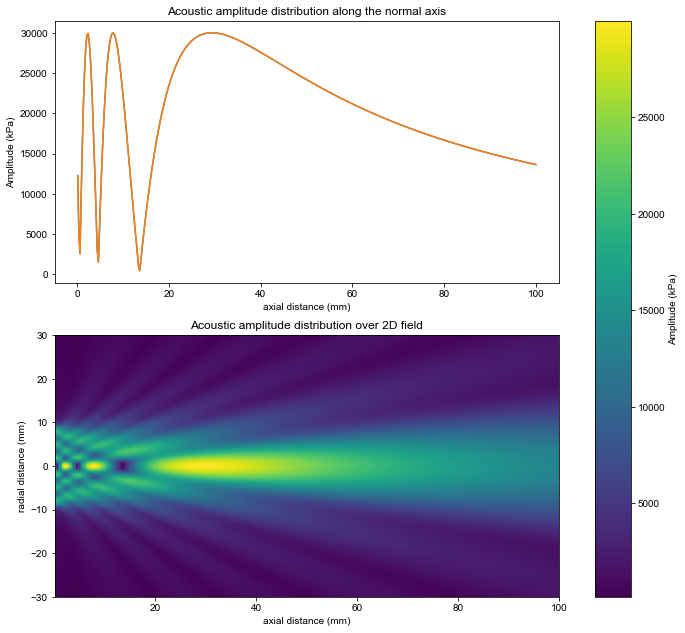

In [8]:
fig.savefig('prop.pdf')

Text(0.5, 0.98, 'trasducerR=9.5mm, Fdrive=500 kHz, focus=0.00mm')

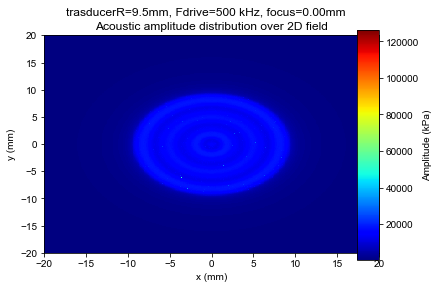

In [10]:
def plotAmp(x, z, amps):
    fig, axes = plt.subplots()
    axes.set_title('Acoustic amplitude distribution over 2D field')
    axes.set_xlabel('x (mm)')
    axes.set_ylabel('y (mm)')
    sm = axes.pcolormesh(y * 1e3, x * 1e3, amps * 1e-3, cmap='jet')  #viridis
    cbarax = fig.add_axes([0.85, 0.10, 0.05, 0.80])
    fig.colorbar(sm, cax=cbarax)
    cbarax.set_ylabel('Amplitude (kPa)')         
    return fig

n = 400
x = np.linspace(-0.02, 0.02, n)  # m
y = np.linspace(-0.02, 0.02, n)  # m

amps = psource.DPSMxy (x, y, psource.z)  # Pa
fig = plotAmp(x, y, amps)
fig.suptitle(f'trasducerR={r_tr*1e3}mm, Fdrive={si_format(Fdrive)}Hz, focus={(psource.z * 1e3):.2f}mm', fontsize=12)

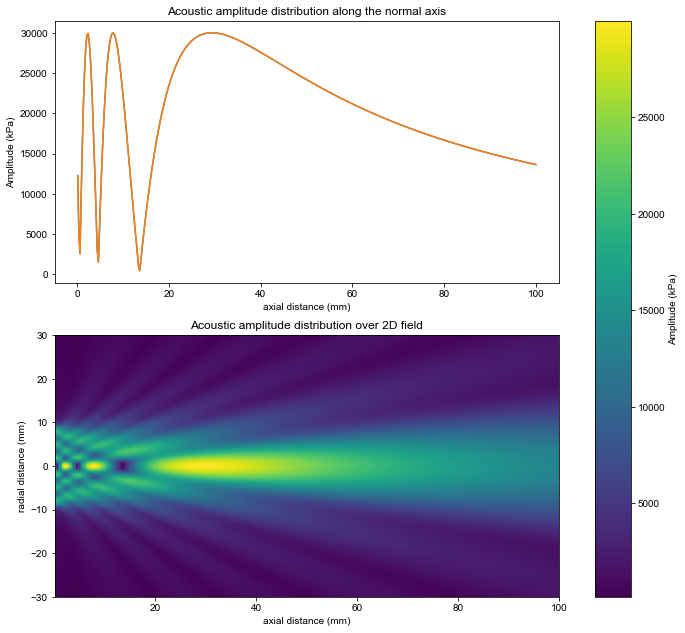

In [8]:
fig.savefig('propaxial.pdf')

{'simkey': 'senn_SONIC', 'neuron': 'FH', 'a': '32nm', 'Fdrive': '500kHz', 'fs': 'fs100%', 'fiberD': 'fiberD5.00um', 'zsource': 'zsource29.33mm', 'tstim_range': 'tstim10.0us-10.0ms'}
{'simkey': 'senn_SONIC', 'neuron': 'FH', 'a': '32nm', 'Fdrive': '500kHz', 'fs': 'fs100%', 'fiberD': 'fiberD12.50um', 'zsource': 'zsource29.33mm', 'tstim_range': 'tstim10.0us-10.0ms'}
{'simkey': 'senn_SONIC', 'neuron': 'FH', 'a': '32nm', 'Fdrive': '500kHz', 'fs': 'fs100%', 'fiberD': 'fiberD20.00um', 'zsource': 'zsource29.33mm', 'tstim_range': 'tstim10.0us-10.0ms'}


<IPython.core.display.Javascript object>


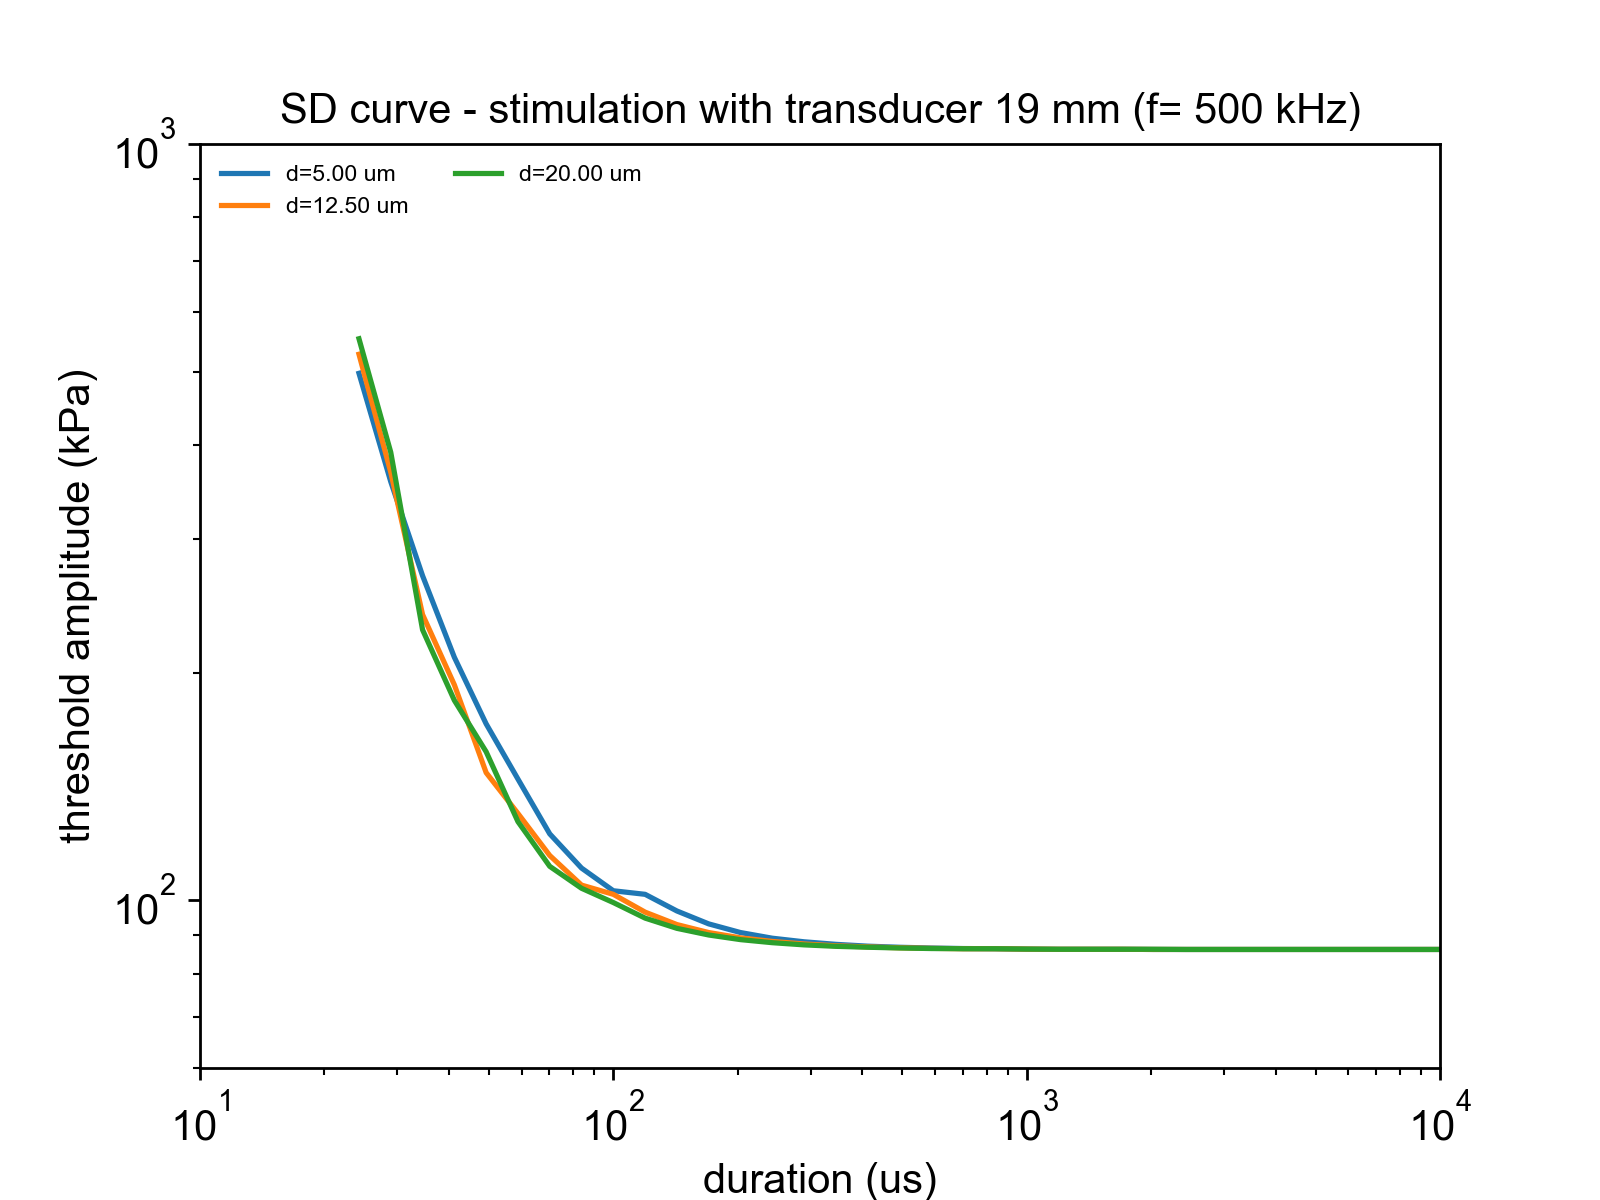

In [12]:
# Stimulation parameters
fiberClass = 'acoustic_planar_transducer' 
toffset = 20e-3  # s
n_dur = 40
tstim_range = np.logspace(-5, 0, n_dur)  # s
freq = 500e3      #(Hz)

outdir='strengthDurationData'
logger.setLevel(logging.WARNING)
Athr_myel = {}

fiberType = 'reilly'
diam_range = np.linspace(5e-6, 20e-6, 3)
for i, fiberD in enumerate(diam_range): 
    df = strengthDuration(fiberType, fiberClass, fiberD, tstim_range, toffset=toffset, outdir=outdir, Fdrive=freq, zdistance='focus', r=r_tr)
    Athr = np.absolute(df.values[:,1])      
    Athr_myel[f'd={(fiberD*1e6):.2f} um'] = Athr
    
fiberType = 'sundt'
diam_range = np.linspace(0.2e-6, 1.5e-6, 3)
for i, fiberD in enumerate(diam_range): 
    df = strengthDuration(fiberType, fiberClass, fiberD, tstim_range, toffset=toffset, outdir=outdir, Fdrive=freq, zdistance='focus', r=r_tr)
    Athr = np.absolute(df.values[:,1])      
    Athr_dict[f'sundt d={(fiberD*1e6):.2f} um'] = Athr

# Plot strength-duration curve
title = 'SD curve - stimulation with transducer 19 mm (f= 500 kHz)'
%matplotlib notebook
colors = plt.get_cmap('tab20c').colors
colors = [colors[2], colors[1], colors[0], colors[6], colors[5], colors[4]]
fig2 = strengthDurationCurve(
    title, tstim_range, Athr_myel,
    yname='amplitude', yfactor=1e-3, yunit='Pa',
    scale='log', plot_chr=False, limits=[6e4, 1e6])

## Transducer 2

In [13]:
u_z = 1                          # transducer surface velocity (m/s)
r_tr = (44e-3) / 2             # transducer radius (m)
x0 = 0                           # transducer location x-axis (m)
y0 = 0                           # transducer location y-axis (m)
z0 = 0                           # transducer location z-axis (m)
Fdrive = 0.5e6   # US frequency
psource = PlanarDiskTransducerSource(x0, y0, z0, Fdrive, r=r_tr) 

<IPython.core.display.Javascript object>


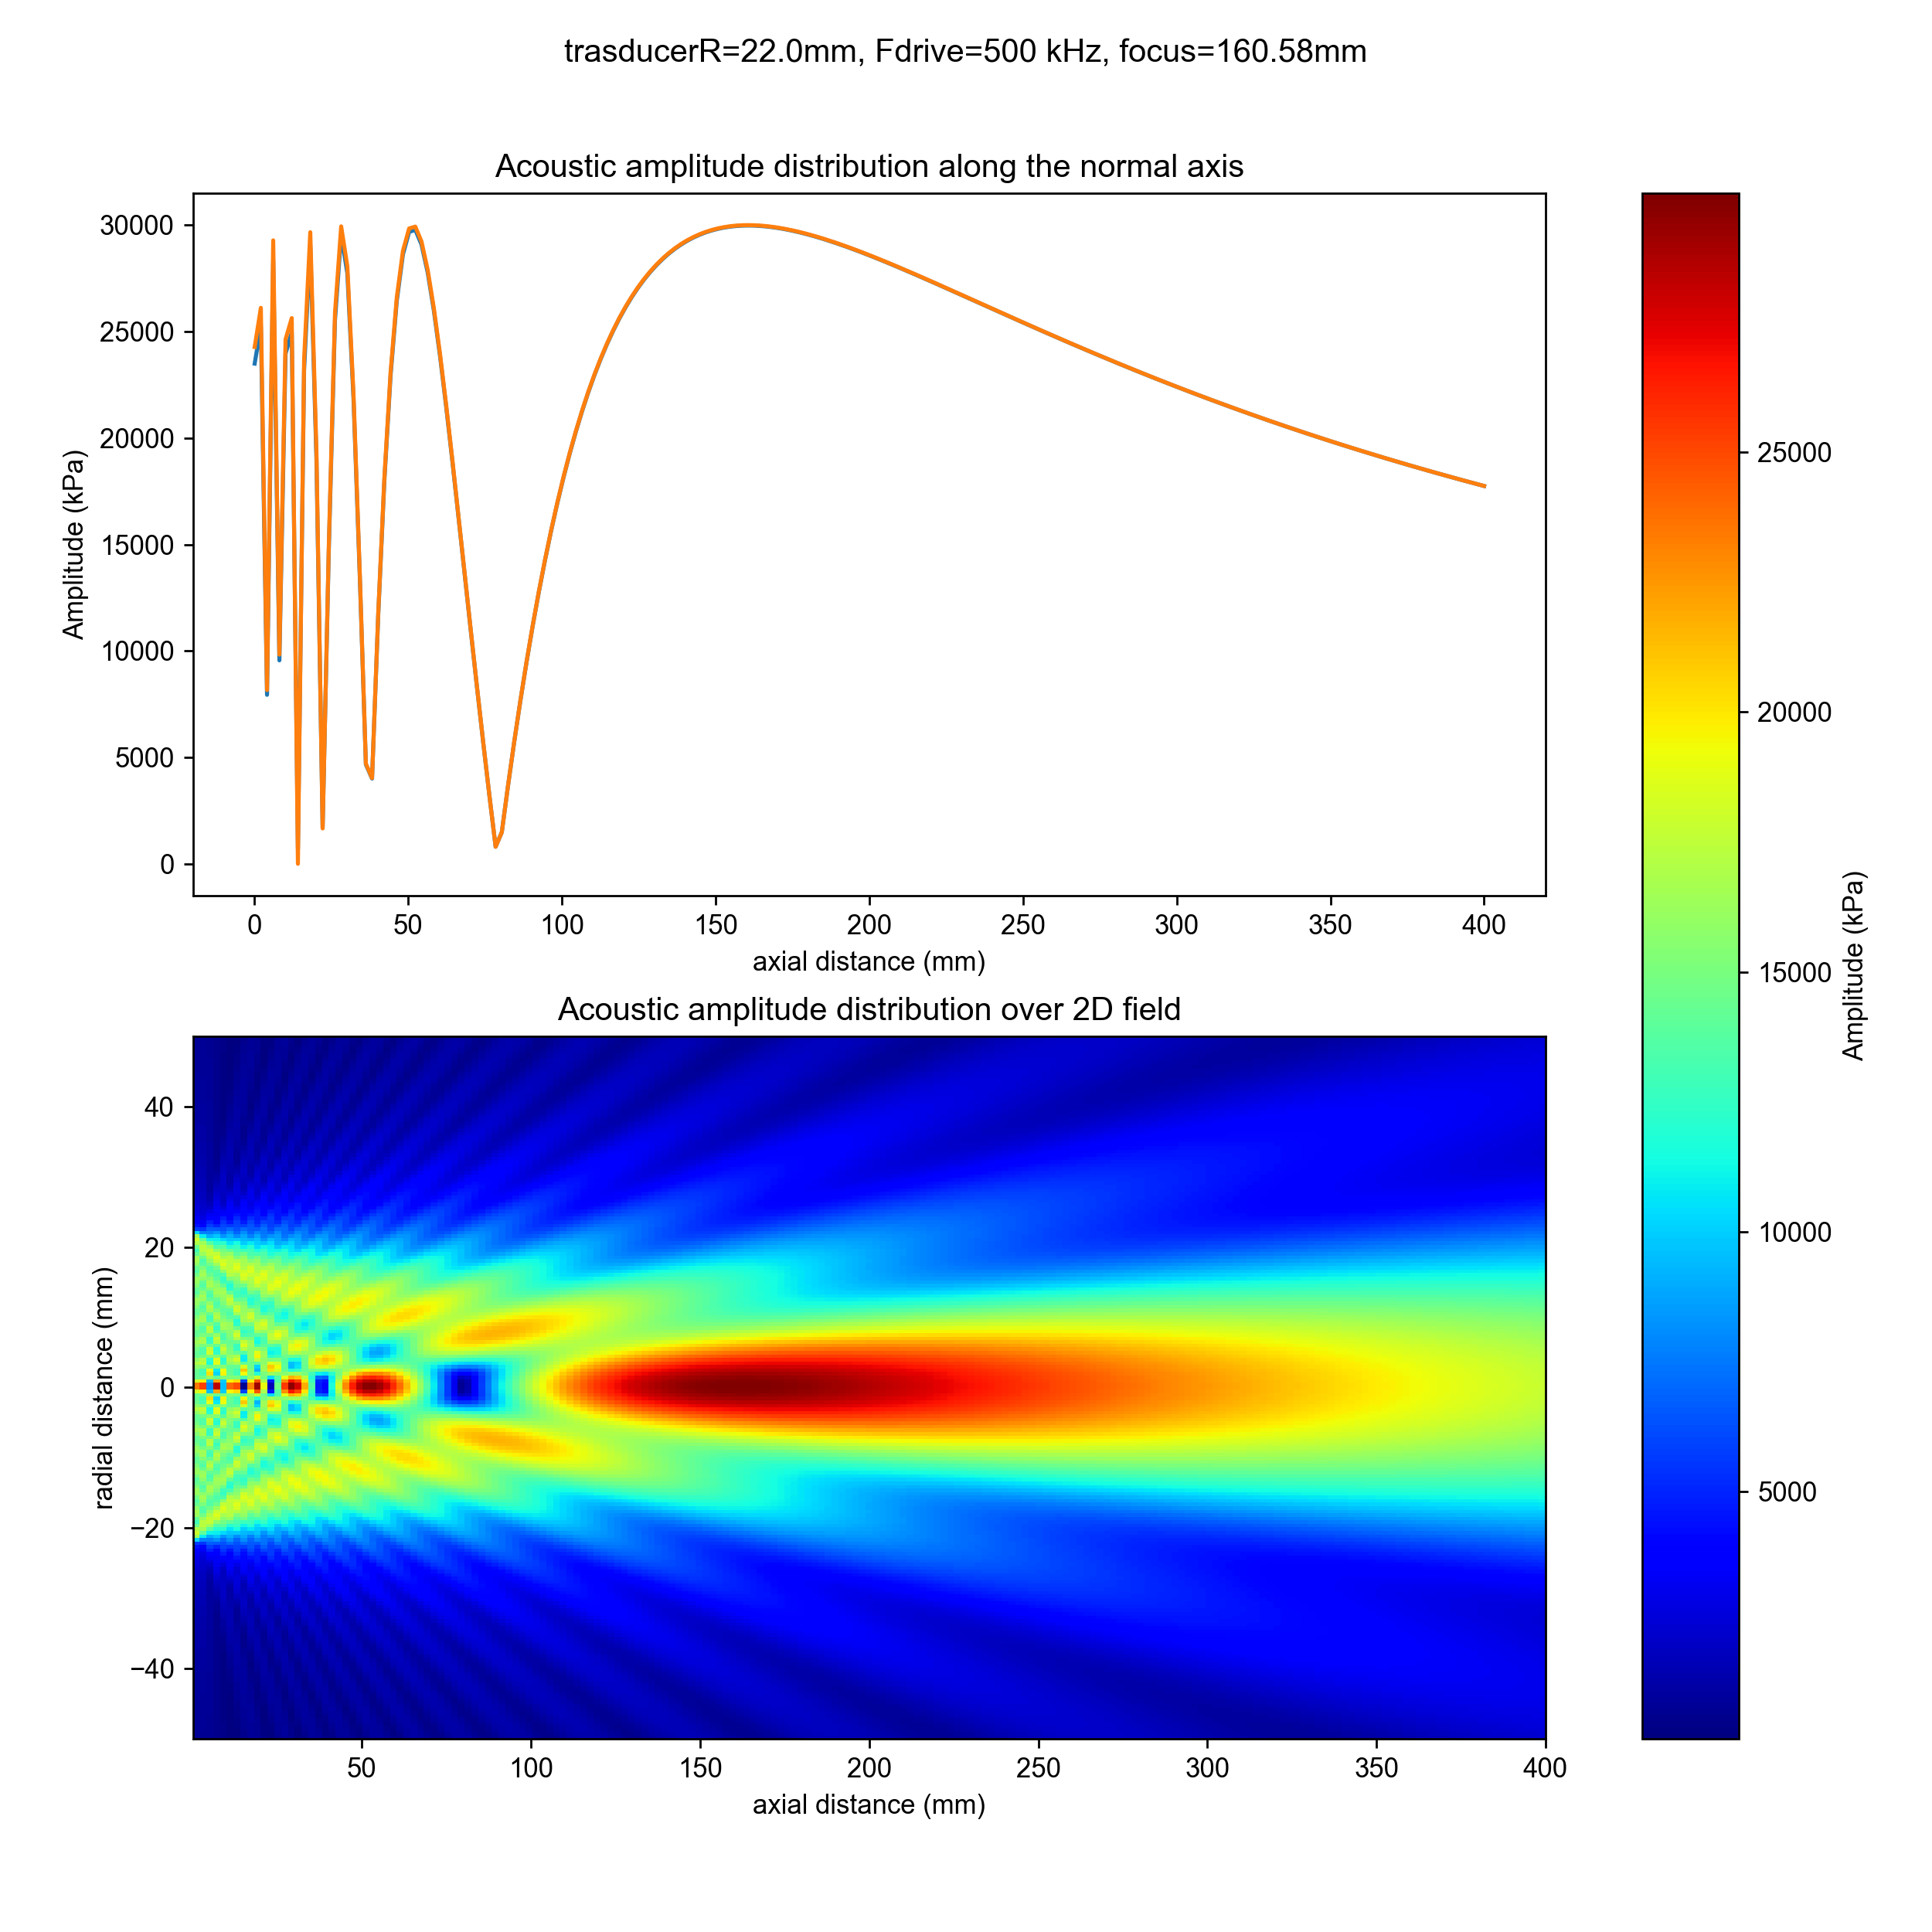

Text(0.5, 0.98, 'trasducerR=22.0mm, Fdrive=500 kHz, focus=160.58mm')

In [14]:
def plotAmpDist(x, z, amps, refamps):
    # Plot amplitude distribution along normal axis and over 2D field
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.80)
    ax = axes[0]
    ax.set_title('Acoustic amplitude distribution along the normal axis')
    ax.set_xlabel('axial distance (mm)')
    ax.set_ylabel('Amplitude (kPa)')
    ax.plot(z * 1e3, amps[int(x.size / 2), :] * 1e-3)
    ax.plot(z * 1e3, refamps * 1e-3)
    ax = axes[1]
    ax.set_title('Acoustic amplitude distribution over 2D field')
    ax.set_xlabel('axial distance (mm)')
    ax.set_ylabel('radial distance (mm)')
    sm = ax.pcolormesh(z * 1e3, x * 1e3, amps * 1e-3, cmap='jet')  #viridis
    cbarax = fig.add_axes([0.85, 0.10, 0.05, 0.80])
    fig.colorbar(sm, cax=cbarax)
    cbarax.set_ylabel('Amplitude (kPa)')         
    return fig

# Generate 2D square grid
n = 200
x = np.linspace(-0.05, 0.05, n)  # m
z = np.linspace(0.0001, 0.4, n)   # m without the first 100 nm

# Plot acoustic amplitudes over 2D grid for each frequency
amps = psource.DPSM2d (x, z, u_z)  # Pa
refamps = psource.normalAxisAmp (z, u_z)
fig = plotAmpDist(x, z, amps, refamps)
fig.suptitle(f'trasducerR={r_tr*1e3}mm, Fdrive={si_format(Fdrive)}Hz, focus={(psource.getFocus()*1e3):.2f}mm', fontsize=12)


<IPython.core.display.Javascript object>


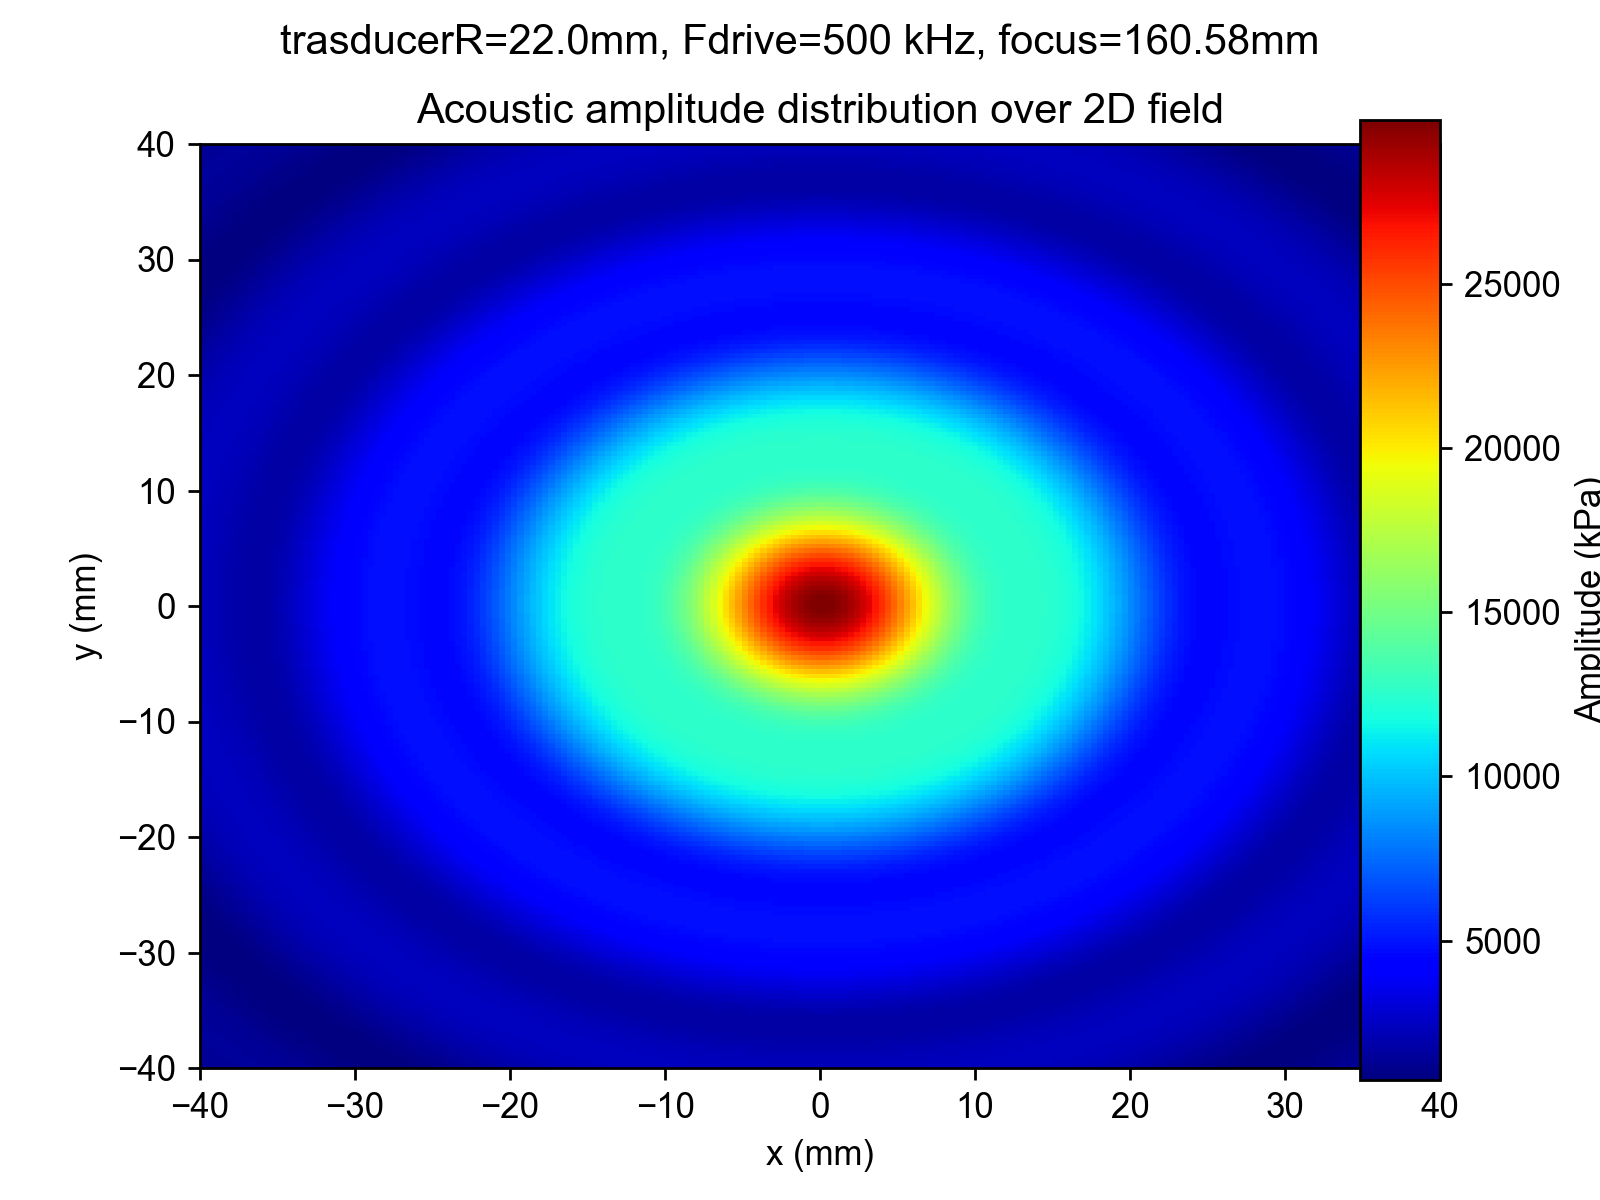

Text(0.5, 0.98, 'trasducerR=22.0mm, Fdrive=500 kHz, focus=160.58mm')

In [15]:
def plotAmp(x, z, amps):
    fig, axes = plt.subplots()
    axes.set_title('Acoustic amplitude distribution over 2D field')
    axes.set_xlabel('x (mm)')
    axes.set_ylabel('y (mm)')
    sm = axes.pcolormesh(y * 1e3, x * 1e3, amps * 1e-3, cmap='jet')  #viridis
    cbarax = fig.add_axes([0.85, 0.10, 0.05, 0.80])
    fig.colorbar(sm, cax=cbarax)
    cbarax.set_ylabel('Amplitude (kPa)')         
    return fig

n = 200
x = np.linspace(-0.03, 0.03, n)  # m
y = np.linspace(-0.03, 0.03, n)  # m
z = psource.getFocus()

amps = psource.DPSMxy (x, y, z, u_z)  # Pa
fig = plotAmp(x, y, amps)
fig.suptitle(f'trasducerR={r_tr*1e3}mm, Fdrive={si_format(Fdrive)}Hz, focus={(psource.getFocus()*1e3):.2f}mm', fontsize=12)

In [ ]:
# Stimulation parameters
fiberClass = 'acoustic_planar_transducer' 
toffset = 20e-3  # s
n_dur = 40
tstim_range = np.logspace(-5, 0, n_dur)  # s
freq = 500e3      #(Hz)

outdir='strengthDurationData'
logger.setLevel(logging.WARNING)
Athr_myel = {}

fiberType = 'reilly'
diam_range = np.linspace(5e-6, 20e-6, 3)
for i, fiberD in enumerate(diam_range): 
    df = strengthDuration(fiberType, fiberClass, fiberD, tstim_range, toffset=toffset, outdir=outdir, Fdrive=freq, zdistance='focus', r=r_tr)
    Athr = np.absolute(df.values[:,1])      
    Athr_myel[f'd={(fiberD*1e6):.2f} um'] = Athr
    
fiberType = 'sundt'
diam_range = np.linspace(0.2e-6, 1.5e-6, 3)
for i, fiberD in enumerate(diam_range): 
    df = strengthDuration(fiberType, fiberClass, fiberD, tstim_range, toffset=toffset, outdir=outdir, Fdrive=freq, zdistance='focus', r=r_tr)
    Athr = np.absolute(df.values[:,1])      
    Athr_dict[f'sundt d={(fiberD*1e6):.2f} um'] = Athr

# Plot strength-duration curve
title = 'SD curve - stimulation with transducer 19 mm (f= 500 kHz)'
%matplotlib notebook
colors = plt.get_cmap('tab20c').colors
colors = [colors[2], colors[1], colors[0], colors[6], colors[5], colors[4]]
fig2 = strengthDurationCurve(
    title, tstim_range, Athr_myel,
    yname='amplitude', yfactor=1e-3, yunit='Pa',
    scale='log', plot_chr=False, limits=[6e4, 1e6])

{'simkey': 'senn_SONIC', 'neuron': 'FH', 'a': '32nm', 'Fdrive': '500kHz', 'fs': 'fs100%', 'fiberD': 'fiberD5.00um', 'zsource': 'zsource160.58mm', 'tstim_range': 'tstim10.0us-1.0s'}


 03/02/2020 14:09:58: No threshold found within the [3.85e-08 - 2.31e-02] interval
 03/02/2020 14:10:03: No threshold found within the [3.85e-08 - 2.31e-02] interval
 03/02/2020 14:10:08: No threshold found within the [3.85e-08 - 2.31e-02] interval


{'simkey': 'senn_SONIC', 'neuron': 'FH', 'a': '32nm', 'Fdrive': '500kHz', 'fs': 'fs100%', 'fiberD': 'fiberD12.50um', 'zsource': 'zsource160.58mm', 'tstim_range': 'tstim10.0us-1.0s'}


 03/02/2020 14:52:46: No threshold found within the [3.85e-08 - 2.31e-02] interval
 03/02/2020 14:52:51: No threshold found within the [3.85e-08 - 2.31e-02] interval
 03/02/2020 14:52:56: No threshold found within the [3.85e-08 - 2.31e-02] interval
